# haveibeenpwned
---
An exploratory analysis into compromised passwords dataset  

Win Nawat Suvansinpan  
DATA512 Final Project

# Introduction
---
Today, data security is one of the top concerns for both individuals and organizations. We all have sensitive information that we want protected. Unfortunately, these information has to be online to be useful. Often, the only thing separating bad actors and our private data is a password. Hacks happen every day and almsot anyone can be a victim of a data breach. [Even Mark Zuckerberg's Twitter was compromised](https://www.theguardian.com/technology/2016/jun/06/mark-zuckerberg-hacked-on-twitter-and-pinterest).

## The problem
It is tempting to set a simple password that is easy to remember. Often, users would construct passwords out of something they are familiar with. This could be a combination of one's name, date of birth, favorite sport or a series of keys on the keyboard. Meanwhile, hacks happen all the time. Once a website is breached, the hackers often dump the obtained data on the internet. This usually involves emails, passwords, and many other private information. These leaked passwords can then form a corpus of common passwords which can be used to help to gain access of other accounts with weak passwords.


## Motivation
The intended outcome is to compel individuals to think twice before setting up passwords for anything. Even if that password is not protecting anything important. This project aims to replace the common caution that is something along the line of "here are the most common passwords. Please avoid using them" with "here are the most common _types_ of password. Please avoid using them." We should not view "=-0987" as any more secure than "123456" since they are essentailly still consecutive keys on the keyboard. They may appear random and hence secure but they may have already been used for thousands of times by hackers.  


## Goals
This project aims to categorize the passwords that have been dumped on the internet into the following buckets.  

- Passwords that are generated from consecutive keys on the keyboard such as "asdfghjk" or "123qweasdzxc."
- Passwords that are a series of numbers in a date format. This is uaually the case for passwords derived from birthdays or important dates such as 11072019 for November 7th 2019.
- Passwords that are vulnerable to dictionary attacks.

The fact that the passwords are hashed allows this project to take the point of view of the bad actors too. This way, it would be possible to show the percentage of most common passwords that can be covered by guessing using the passwords from the abovementioned categories alone.

Another goal of the project would be to uncover how the counts of compromised passwords changed in one year. This is made possible because there are two versions of the data set that were updated one year apart. The latest version of the data was updated on July 2019. The earlier version of the data was updated on July 2018.

In addition, this project serves as an exercise on how to analyze and present dataset with sensitive data without actually revealing them. All passwords used in here are hashed to protect any personal information, and any passwords that are generated by scripts are hashed as well.

# Dataset
---
### compromised passwords
The data used in this study is taken from a website by Troy Hunt [haveibeenpwned.com](https://haveibeenpwned.com/Passwords). Troy is a  Microsoft Regional Director and Microsoft Most Valuable Professional for Developer Security and a significant contributor in the cybersecurity community. Troy has made the data freely available to the public with no license and he has persoanlly allowed the dataset to be used for this project.  
The generated passwords according to the above categories will then be hashed and compared against this list to check if they appear on the list at all and if so, how many times have they been leaked.

There are two versions of the data.

1. The most recent version is V.5 which is available on [haveibeenpwned.com](https://haveibeenpwned.com/Passwords). This V.5 data set was updated as of July 2019.
2. V.3 is available on the [internet archive](https://archive.org/details/academictorrents_53555c69e3799d876159d7290ea60e56b35e36a9) and was updated on July 2018.  

The dataset is a list of hashed(SHA-1) passwords that have been compromised and the corresponding number of times they appear on data dumps. The compromised passwords are gathered by Troy himself from various data dumps on the internet. He kept on adding new entries and increment the counts of the passwords that are already on the list as new dumps happened. 

Each data set is an approximately 10GB text file. The rows are sorted accoring to their counts. To host the data on Github, the data sets will have to be trimmed to Github's file size limit. That is, the passwords that were leaked before but have counts below a certain value will have to be omitted.

#### Format of the data (for both versions)

|passwords|number of times the password appears on a dump|
|----|----|
|hashed password1|count_1|
|hashed password2|count_2|
|...|...|
|hashed password_n|count_n|

### wordlist for dictionary attack
The worlist used for dictionary attack used in this project is compiled by [Openwall.com](https://www.openwall.com/). The worlist is licensed for use and redistribution. No modification was made and the "tiny" version is used.

## Potential limitations
The data is manually gathered and appended by Troy Hunt. This may not be reflective of the complete population of the hacked passwords as not every hacked data is released in data dumps. Also the sources he obtain the data dumps from may not be representative of all the compromised passwords.

## Related Work
There are numerous articles and researches about the most common passwords. In fact, the list is published yearly.
- https://www.teamsid.com/splashdatas-top-100-worst-passwords-of-2018/

An analysis on the common passwords' characteristics such as length and character composition.
- https://blog.binaryedge.io/2017/07/24/antipublic-password-analysis/

## Hypothesis

**Majority** of vulnerable passwords belong to the following categories:
- Keyboard walk 		(“asdfghjk”, “qwerty”)
- Dates 				(“12052019”)
- Dictionary attack 	(“password” “admin” “welcome”)

## Research questions
1) What is the proportion of the passwords that can be classified under the categories above?

2) How do the counts of the different categories of compromised passwords change within a year?

# Methodology
---

The overarching idea is to "guess" the hashed passwords by generating passwords under the 3 categories stated above, hash them, and check them against the hashed passwords in the data set using left join based on hash. All the scripting, exploration and reporting are done in Python 3 via Jupyter notebook.
- keyboard walk passwords are generated by a script that create permutations of n-grams of the consecutive characters on the keyboard. Both row and column wise.
- date-formatted passwords are generated by creating a date list within a specified timeframe, rearranging the dates into different formats (day-month-year, month-day-year, year-month-day), convert them to numbers, hash them and compare against the dataset.
- dictionary attack uses compiled wordlist by openwall.com and hash them. The hashed words are then compared against the data set.
Throughout the process, the generated passwords are never revealed as the passwords are hashed and saved and then joined to the main dataset.  
The subsequent data analysis and visualization only uses the granularity of category which is sufficient to answer the research questions in this case.

# Analysis
---

Since generating passwords is a compute-intensive task, there are variables in the cell below that can be set to help with reproducibility. The default value bypasses some of the intensive tasks and load pre-generated data instead.

In [428]:
# Set the checkpoint value. If True, the notebook will load a matched_hashes.csv and produce the finished dataset.
# All the keyboard walk password comparison will be bypassed.

checkpoint = True

# Set the keyboard_rerun value. If True, the notebook will run the keyboard walk hashed passwords generation again.
# This takes an extremely long time.

keyboard_rerun = False

## Reading the data and setting up helper functions

In [429]:
import hashlib
import itertools as it
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
%matplotlib inline

### Helper functions

In [430]:
def tuptostring(tup):
    '''
    This function takes in a tuple and output 
    a single string of all the members of the tuples concatenated.
    '''
    somestring =  ''.join(tup) 
    return somestring

def writetofile_qwerty(ngramseedlist, passlength, category):
    '''
    This function generates all possible combinations of theelements of the n-grams fed as a seed list.
    The generated passwords are hashed and stored as a row in a text file in the form of
    hashed password:password length.
    The argument passlength defines the length of the password being generated.
    Category is the name of the category of the password being generated.
    In this project, it is kept as "keyboard-walk"
    '''
    seedlength = len(ngramseedlist[0][0])
    new_n = round(passlength/seedlength+0.49)
    for seedlist in ngramseedlist:
        outF = open(category+".txt", "a")
        for p in it.product(seedlist, repeat=new_n):
            p = tuptostring(p)
            p = p[:passlength]
            p = hashlib.sha1(p.encode()).hexdigest().upper()
            outF.write(p)
            outF.write(":")
            outF.write(str(passlength))
            outF.write("\n")
        outF.close()
        
def checkmasterlist_date(masterdf, datelist, category):
    '''
    This function takes in a dataframe, a date list and a category.
    The dataframe is the table of hased passwords.
    The datelist is the list of dates interested.
    The funciton then day-month-year, month-day-year,
    and year-month-day combinations of the dates and check against
    the hashed passwords in the dataframe.
    Category argument is the name of the category.
    In this project, it is kept as "date-pwd"
    '''
    passwordlist = []
    for date in datelist:
        dmy = date.strftime("%d%m%Y")
        dmy = hashlib.sha1(dmy.encode()).hexdigest().upper()
        passwordlist.append(dmy)
        mdy = date.strftime("%m%d%Y")
        mdy = hashlib.sha1(mdy.encode()).hexdigest().upper()
        passwordlist.append(mdy)
        ymd = date.strftime("%Y%m%d")
        ymd = hashlib.sha1(ymd.encode()).hexdigest().upper()
        passwordlist.append(ymd)

    hashed_df = pd.DataFrame(passwordlist, columns=["hash"])
    hashed_df[category] = True
    hashed_df["length"] = 8
    masterdf = masterdf.join(hashed_df.set_index("hash"), on="hash", rsuffix="_new", how='left')
    masterdf.fillna(False, inplace=True)
    del(hashed_df)
    try:
        masterdf[category] = masterdf[category] | masterdf[category+"_new"]
        masterdf.drop(columns=[category+"_new"], inplace=True)
        masterdf["length"] = masterdf.fillna(0)["length"]
        masterdf["length"+"_new"] = masterdf.fillna(0)["length"+"_new"]
        masterdf["length"] = masterdf[["length", "length"+"_new"]].max(axis=1)
        #masterdf["length"] = masterdf.fillna(0)["length"] + masterdf.fillna(0)["length"+"_new"]
        masterdf.drop(columns=["length"+"_new"], inplace=True)
    except:
        pass
    masterdf = masterdf.drop_duplicates(subset="hash")
    return masterdf

### Rows and columns of characters for keyboard walks
This will then be used to generate the n-grams used as seedlist for keyboard walk passwords

In [431]:
firstrow = "1234567890-="
firstrow_rev = firstrow[::-1]
secondrow = "qwertyuiop[]"
secondrow_rev = secondrow[::-1]
thirdrow = "asdfghjkl;"
thirdrow_rev = thirdrow[::-1]
fourthrow = "zxcvbnm,."
fourthrow_rev = fourthrow[::-1]
specialrow = "abcdefghijkl"
rowlist = [firstrow,
          firstrow_rev,
          secondrow,
          secondrow_rev,
          thirdrow,
          thirdrow_rev,
          fourthrow,
          fourthrow_rev,
          specialrow]

allcol = "1qaz2wsx3edc4rfv5tgb6yhn7ujm8ik,9ol."
allcol_rev = allcol[::-1]

collist = [allcol, allcol_rev]

### Creating n-grams from the rows and columns from above
A list of n-grams is created for every row. They are then conbined into one seedlist for row.
maxpasslen defines the maximum length of the password being considered in this study.

In [432]:
ngram_seedlist = []
numeric_seedlist = []
maxpasslen = 12

numbers = firstrow[0:10]
numbers = [numbers[i:i+1] for i in range(len(numbers))]
numeric_seedlist.append(numbers)

for n in [2,3,5,7]:
    repeatcount = round(maxpasslen/n+0.5)
    
    combinedrows = []
    for row in rowlist:
        somelist = [row[i:i+n] for i in range(len(row)-n+1)]
        combinedrows = combinedrows + somelist
    ngram_seedlist.append(combinedrows)
     
    combinedcols = []
    for col in collist:
        somelist = [col[i:i+n] for i in range(len(col)-n+1)]
        if somelist:
            combinedcols = combinedcols + somelist
    ngram_seedlist.append(combinedcols)

### Generating all possible passwords for keyboard walk
The writetofile_qwerty function is run twice.
- The first run is to generate passwords of length 4-7 characters. This is a quick run and is used as a sanity check.
- The second run generates password length of 7-12 characters. Given the length, the entropy is extremely high and therefore this cell takes extremely long to run.

In [433]:
# First run. 4-6 character-long passwords.
if keyboard_rerun == True:
    for i in range(4,7):
        writetofile_qwerty(ngram_seedlist,i,"keyboard-walk")

In [434]:
# Second run. 7-12 character-long passwords.
# The file path is different from the first run due to computer space limitations.
# Modify the file path before running.
if keyboard_rerun == True:
    for i in range(7,13):
        writetofile_qwerty(ngram_seedlist,i,"/mnt/d/keyboard-walk")

### Reading the data - v5

In [435]:
hashedlistv5 = pd.read_csv("./top50kv5.csv", index_col=0)

In [436]:
if checkpoint == True:
    matched_hashes_v5 = pd.read_csv("matched_hashes_v5.csv", index_col=0)
    hashedlistv5 = hashedlistv5.join(matched_hashes_v5.set_index("hash"), on="hash", rsuffix="_new", how='left')
    hashedlistv5["length"] = hashedlistv5.fillna(0)["length"]
    hashedlistv5 = hashedlistv5.fillna(False)

In [437]:
hashedlistv5.head(5)

,hash,count,length,keyboard-walk,date-pwd,dictionary-atk
0,7C4A8D09CA3762AF61E59520943DC26494F8941B,23547453,6.0,True,False,False
1,F7C3BC1D808E04732ADF679965CCC34CA7AE3441,7799814,9.0,True,False,False
2,B1B3773A05C0ED0176787A4F1574FF0075F7521E,3912816,6.0,True,False,False
3,5BAA61E4C9B93F3F0682250B6CF8331B7EE68FD8,3730471,8.0,False,False,True
4,3D4F2BF07DC1BE38B20CD6E46949A1071F9D0E3D,3120735,0.0,False,False,False


### Checking the hashed passwords against the data set - keyboard walk
Here, the files generated by writetofile_qwerty are read by chunks and compared against the hashed passwords dataset. The two cells below read the text files from the working directory and drive D respectively. To reproduce, the file locations will have to be changed accordingly.

In [438]:
if checkpoint == False:
    chunksize = 100000
    runcount = 0
    for chunk in pd.read_csv("keyboard-walk.txt", chunksize=chunksize, sep=":", names=["hash","length"]):
        hashed_df = chunk
        del(chunk)
        hashed_df["keyboard-walk"] = True
        hashedlistv5 = hashedlistv5.join(hashed_df.set_index("hash"), on="hash", rsuffix="_new", how='left')
        hashedlistv5[["keyboard-walk"]] = hashedlistv5[["keyboard-walk"]].fillna(False)
        del(hashed_df)
        try:
            hashedlistv5["keyboard-walk"] = hashedlistv5["keyboard-walk"] | hashedlistv5["keyboard-walk"+"_new"]
            hashedlistv5["length"] = hashedlistv5.fillna(0)["length"]
            hashedlistv5["length"+"_new"] = hashedlistv5.fillna(0)["length"+"_new"]
            hashedlistv5["length"] = hashedlistv5[["length", "length"+"_new"]].max(axis=1)
            hashedlistv5.drop(columns=["keyboard-walk"+"_new"], inplace=True)
            hashedlistv5.drop(columns=["length"+"_new"], inplace=True)
        except:
            pass
        runcount += 1
        hashedlistv5 = hashedlistv5.drop_duplicates(subset="hash")
    print(hashedlistv5.groupby("keyboard-walk").count())

In [439]:
if checkpoint == False:
    chunksize = 100000
    runcount = 0
    for chunk in pd.read_csv("/mnt/d/keyboard-walk.txt", chunksize=chunksize, sep=":", names=["hash","length"]):
        hashed_df = chunk
        del(chunk)
        hashed_df["keyboard-walk"] = True
        hashedlistv5 = hashedlistv5.join(hashed_df.set_index("hash"), on="hash", rsuffix="_new", how='left')
        hashedlistv5[["keyboard-walk"]] = hashedlistv5[["keyboard-walk"]].fillna(False)
        del(hashed_df)
        try:
            hashedlistv5["keyboard-walk"] = hashedlistv5["keyboard-walk"] | hashedlistv5["keyboard-walk"+"_new"]
            hashedlistv5["length"] = hashedlistv5.fillna(0)["length"]
            hashedlistv5["length"+"_new"] = hashedlistv5.fillna(0)["length"+"_new"]
            hashedlistv5["length"] = hashedlistv5[["length", "length"+"_new"]].max(axis=1)
            hashedlistv5.drop(columns=["keyboard-walk"+"_new"], inplace=True)
            hashedlistv5.drop(columns=["length"+"_new"], inplace=True)
        except:
            pass
        runcount += 1
        hashedlistv5 = hashedlistv5.drop_duplicates(subset="hash")
    print(hashedlistv5.groupby("keyboard-walk").count())

In [440]:
print(hashedlistv5.groupby("keyboard-walk").count())

                hash  count  length  date-pwd  dictionary-atk
keyboard-walk                                                
False          48914  48914   48914     48914           48914
True            1086   1086    1086      1086            1086


### Checking the hashed passwords against the data set - date-formatted passwords

In [441]:
datelist = pd.date_range(start='1940-1-1', end='2019-12-04').tolist()

In [442]:
hashedlistv5 = checkmasterlist_date(hashedlistv5, datelist, "date-pwd")
print(hashedlistv5.groupby("date-pwd").count())

           hash  count  length  keyboard-walk  dictionary-atk
date-pwd                                                     
False     47567  47567   47567          47567           47567
True       2433   2433    2433           2433            2433


In [443]:
hashedlistv5[hashedlistv5["date-pwd"] == True].head()

,hash,count,length,keyboard-walk,date-pwd,dictionary-atk
2418,9BA7ECEC08C27DFB1E42D4FA2831FC827E9A2D4B,38327,8.0,False,True,False
3158,C743A4291BAAB121576A625792D96D7337996929,31244,8.0,False,True,False
3448,8E1B124B9B5AE4E0821A24F27DFBBE6CC33FD754,29308,8.0,False,True,False
5601,704B3B569EF07A48EF03138AA87A13D4746333F9,19994,8.0,False,True,False
6223,4444D426502FE6C435DEBB47A8418BE34F20BDE1,18314,8.0,False,True,False


### Checking the hashed passwords against the data set - dictionary attack

In [444]:
chunksize = 50000
for chunk in pd.read_csv("lower.lst", chunksize=chunksize, sep=":", names=["password"]):
    hashed_df = chunk
    del(chunk)
    hashed_df["dictionary-atk"] = True
    hashed_df['length'] = hashed_df['password'].apply(lambda x: len(str(x)))
    hashed_df['hash'] = hashed_df['password'].apply(lambda x: hashlib.sha1(str(x).encode()).hexdigest().upper())
    hashed_df.drop(columns=['password'], inplace=True)
    hashedlistv5 = hashedlistv5.join(hashed_df.set_index("hash"), on="hash", rsuffix="_new", how='left')
    hashedlistv5[["dictionary-atk"]] = hashedlistv5[["dictionary-atk"]].fillna(False)
    del(hashed_df)
    try:
        hashedlistv5[["dictionary-atk"+"_new"]] = hashedlistv5[["dictionary-atk"+"_new"]].fillna(False)
        hashedlistv5["dictionary-atk"] = hashedlistv5["dictionary-atk"] | hashedlistv5["dictionary-atk"+"_new"]
        hashedlistv5["length"+"_new"] = hashedlistv5.fillna(0)["length"+"_new"]
        hashedlistv5["length"] = hashedlistv5[["length", "length"+"_new"]].max(axis=1)
        hashedlistv5.drop(columns=["dictionary-atk"+"_new"], inplace=True)
        hashedlistv5.drop(columns=["length"+"_new"], inplace=True)
    except:
        hashedlistv5.drop(columns=["length"+"_new"], inplace=True)
        pass
    hashedlistv5 = hashedlistv5.drop_duplicates(subset="hash")
print(hashedlistv5.groupby("dictionary-atk").count())

                 hash  count  length  keyboard-walk  date-pwd
dictionary-atk                                               
False           42532  42532   42532          42532     42532
True             7468   7468    7468           7468      7468


In [445]:
hashedlistv5.head(5)

,hash,count,length,keyboard-walk,date-pwd,dictionary-atk
0,7C4A8D09CA3762AF61E59520943DC26494F8941B,23547453,6.0,True,False,False
1,F7C3BC1D808E04732ADF679965CCC34CA7AE3441,7799814,9.0,True,False,False
2,B1B3773A05C0ED0176787A4F1574FF0075F7521E,3912816,6.0,True,False,False
3,5BAA61E4C9B93F3F0682250B6CF8331B7EE68FD8,3730471,8.0,False,False,True
4,3D4F2BF07DC1BE38B20CD6E46949A1071F9D0E3D,3120735,0.0,False,False,False


In [446]:
print(hashedlistv5.groupby("keyboard-walk").count()) # 315138 -> 334266
print(hashedlistv5.groupby("date-pwd").count()) # 41144?
print(hashedlistv5.groupby("dictionary-atk").count()) # 40316

                hash  count  length  date-pwd  dictionary-atk
keyboard-walk                                                
False          48914  48914   48914     48914           48914
True            1086   1086    1086      1086            1086
           hash  count  length  keyboard-walk  dictionary-atk
date-pwd                                                     
False     47567  47567   47567          47567           47567
True       2433   2433    2433           2433            2433
                 hash  count  length  keyboard-walk  date-pwd
dictionary-atk                                               
False           42532  42532   42532          42532     42532
True             7468   7468    7468           7468      7468


---

## Reading the data - v3

In [447]:
hashedlistv3 = pd.read_csv("./top50kv3.csv", index_col=0)

In [448]:
if checkpoint == True:
    matched_hashes_v3 = pd.read_csv("matched_hashes_v3.csv", index_col=0)
    hashedlistv3 = hashedlistv3.join(matched_hashes_v3.set_index("hash"), on="hash", rsuffix="_new", how='left')
    hashedlistv3["length"] = hashedlistv3.fillna(0)["length"]
    hashedlistv3 = hashedlistv3.fillna(False)

In [449]:
hashedlistv3.head()

,hash,count,length,keyboard-walk,date-pwd,dictionary-atk
0,7C4A8D09CA3762AF61E59520943DC26494F8941B,22390492,6.0,True,False,False
1,F7C3BC1D808E04732ADF679965CCC34CA7AE3441,7481454,9.0,True,False,False
2,B1B3773A05C0ED0176787A4F1574FF0075F7521E,3752262,6.0,True,False,False
3,5BAA61E4C9B93F3F0682250B6CF8331B7EE68FD8,3533661,8.0,False,False,True
4,3D4F2BF07DC1BE38B20CD6E46949A1071F9D0E3D,3006809,0.0,False,False,False


### Checking the hashed passwords against the data set - keyboard walk
Here, the files generated by writetofile_qwerty are read by chunks and compared against the hashed passwords dataset. The two cells below read the text files from the working directory and drive D respectively. To reproduce, the file locations will have to be changed accordingly.

In [450]:
if checkpoint == False:
    chunksize = 100000
    runcount = 0
    for chunk in pd.read_csv("keyboard-walk.txt", chunksize=chunksize, sep=":", names=["hash","length"]):
        hashed_df = chunk
        del(chunk)
        hashed_df["keyboard-walk"] = True
        hashedlistv3 = hashedlistv3.join(hashed_df.set_index("hash"), on="hash", rsuffix="_new", how='left')
        hashedlistv3[["keyboard-walk"]] = hashedlistv3[["keyboard-walk"]].fillna(False)
        del(hashed_df)
        try:
            hashedlistv3["keyboard-walk"] = hashedlistv3["keyboard-walk"] | hashedlistv3["keyboard-walk"+"_new"]
            hashedlistv3["length"] = hashedlistv3.fillna(0)["length"]
            hashedlistv3["length"+"_new"] = hashedlistv3.fillna(0)["length"+"_new"]
            hashedlistv3["length"] = hashedlistv3[["length", "length"+"_new"]].max(axis=1)
            hashedlistv3.drop(columns=["keyboard-walk"+"_new"], inplace=True)
            hashedlistv3.drop(columns=["length"+"_new"], inplace=True)
        except:
            pass
        runcount += 1
        hashedlistv3 = hashedlistv3.drop_duplicates(subset="hash")
    print(hashedlistv3.groupby("keyboard-walk").count())

In [451]:
if checkpoint == False:
    chunksize = 100000
    runcount = 0
    for chunk in pd.read_csv("/mnt/d/keyboard-walk.txt", chunksize=chunksize, sep=":", names=["hash","length"]):
        hashed_df = chunk
        del(chunk)
        hashed_df["keyboard-walk"] = True
        hashedlistv3 = hashedlistv3.join(hashed_df.set_index("hash"), on="hash", rsuffix="_new", how='left')
        hashedlistv3[["keyboard-walk"]] = hashedlistv3[["keyboard-walk"]].fillna(False)
        del(hashed_df)
        try:
            hashedlistv3["keyboard-walk"] = hashedlistv3["keyboard-walk"] | hashedlistv3["keyboard-walk"+"_new"]
            hashedlistv3["length"] = hashedlistv3.fillna(0)["length"]
            hashedlistv3["length"+"_new"] = hashedlistv3.fillna(0)["length"+"_new"]
            hashedlistv3["length"] = hashedlistv3[["length", "length"+"_new"]].max(axis=1)
            hashedlistv3.drop(columns=["keyboard-walk"+"_new"], inplace=True)
            hashedlistv3.drop(columns=["length"+"_new"], inplace=True)
        except:
            pass
        runcount += 1
        hashedlistv3 = hashedlistv3.drop_duplicates(subset="hash")
    print(hashedlistv3.groupby("keyboard-walk").count())

### Checking the hashed passwords against the data set - date-formatted passwords

In [452]:
hashedlistv3 = checkmasterlist_date(hashedlistv3, datelist, "date-pwd")
print(hashedlistv3.groupby("date-pwd").count())

           hash  count  length  keyboard-walk  dictionary-atk
date-pwd                                                     
False     47517  47517   47517          47517           47517
True       2483   2483    2483           2483            2483


### Checking the hashed passwords against the data set - dictionary attack

In [453]:
chunksize = 50000
for chunk in pd.read_csv("lower.lst", chunksize=chunksize, sep=":", names=["password"]):
    hashed_df = chunk
    del(chunk)
    hashed_df["dictionary-atk"] = True
    hashed_df['length'] = hashed_df['password'].apply(lambda x: len(str(x)))
    hashed_df['hash'] = hashed_df['password'].apply(lambda x: hashlib.sha1(str(x).encode()).hexdigest().upper())
    hashed_df.drop(columns=['password'], inplace=True)
    hashedlistv3 = hashedlistv3.join(hashed_df.set_index("hash"), on="hash", rsuffix="_new", how='left')
    hashedlistv3[["dictionary-atk"]] = hashedlistv3[["dictionary-atk"]].fillna(False)
    del(hashed_df)
    try:
        hashedlistv3[["dictionary-atk"+"_new"]] = hashedlistv3[["dictionary-atk"+"_new"]].fillna(False)
        hashedlistv3["dictionary-atk"] = hashedlistv3["dictionary-atk"] | hashedlistv3["dictionary-atk"+"_new"]
        hashedlistv3.drop(columns=["dictionary-atk"+"_new"], inplace=True)
        hashedlistv3["length"+"_new"] = hashedlistv3.fillna(0)["length"+"_new"]
        hashedlistv3["length"] = hashedlistv3[["length", "length"+"_new"]].max(axis=1)
        hashedlistv3.drop(columns=["length"+"_new"], inplace=True)
    except:
        print("try error")
        hashedlistv3.drop(columns=["length"+"_new"], inplace=True)
        pass
    hashedlistv3 = hashedlistv3.drop_duplicates(subset="hash")
print(hashedlistv3.groupby("dictionary-atk").count())

                 hash  count  length  keyboard-walk  date-pwd
dictionary-atk                                               
False           42571  42571   42571          42571     42571
True             7429   7429    7429           7429      7429


# Results
---
Discussed below are the findings.

## Generating the dataframe for bar plots
The following cells extract the count from each category and tabulate them into a dataframe suitable for plotting

In [454]:
keyboard_walk_v3 = int(hashedlistv3.groupby("keyboard-walk").count()["hash"][1:2])
date_pwd_v3 = int(hashedlistv3.groupby("date-pwd").count()["hash"][1:2])
dictionary_v3 = int(hashedlistv3.groupby("dictionary-atk").count()["hash"][1:2])
uncategorized_v3 = 50000 - keyboard_walk_v3 - date_pwd_v3 - dictionary_v3
keyboard_walk_v5 = int(hashedlistv5.groupby("keyboard-walk").count()["hash"][1:2])
date_pwd_v5 = int(hashedlistv5.groupby("date-pwd").count()["hash"][1:2])
dictionary_v5 = int(hashedlistv5.groupby("dictionary-atk").count()["hash"][1:2])
uncategorized_v5 = 50000 - keyboard_walk_v5 - date_pwd_v5 - dictionary_v5

In [455]:
plot_this = pd.DataFrame({"v3":[keyboard_walk_v3,date_pwd_v3,dictionary_v3,uncategorized_v3],
             "v5" :[keyboard_walk_v5,date_pwd_v5,dictionary_v5,uncategorized_v5]})

In [456]:
plot_this.index = ["keyboard-walk", "date-pwd", "dictionary-atk", 'uncategorized']
plot_this = plot_this.transpose()
plot_this

,keyboard-walk,date-pwd,dictionary-atk,uncategorized
v3,1083,2483,7429,39005
v5,1086,2433,7468,39013


## Hypothesis:
**Majority** of vulnerable passwords belong to the following categories:
- Keyboard walk 		(“asdfghjk”, “qwerty”)
- Dates 				(“12052019”)
- Dictionary attack 	(“password” “admin” “welcome”)

From the plot below, we can see that the passwords that fall into the 3 categories are still a minority of the compromised passwords.

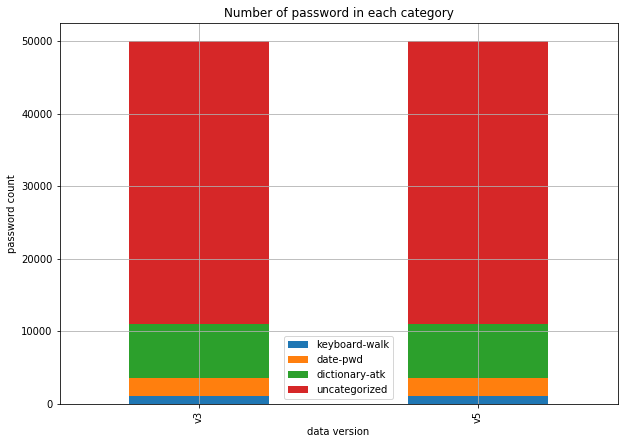

In [457]:
ax = plot_this.loc[:,['keyboard-walk','date-pwd','dictionary-atk','uncategorized']].plot.bar(stacked=True, 
                                                                                        figsize=(10,7),
                                                                                        grid=True,
                                                                                        title='Number of password in each category')
ax.set_xlabel("data version")
ax.set_ylabel("password count")
plt.savefig("all-results")

## Result: Hypothesis rejected.
Majority of the top 50k passwords are still uncategorized. 

## Research Qn. 1:
What is the proportion of the passwords that can be classified under the categories above?

## Result:
Approximately 20% of the compromised passwords can be categorized into the hypothesized categories. Also, we do not see a noticeable change in the proportion of the categories within the past 1 year

## Fruther exploration 1
Looking at the passwords that have been categorized only, the most common category is dictionary attack. This shows that the very basic form of penetration testing is still the most effective, at least for the very weak passwords. Interestingly, the date-format passwords appear more often than keyboard walk passwords on the top 50,000 weakest password list.  
No noticeable change in the categories' proportions here either.

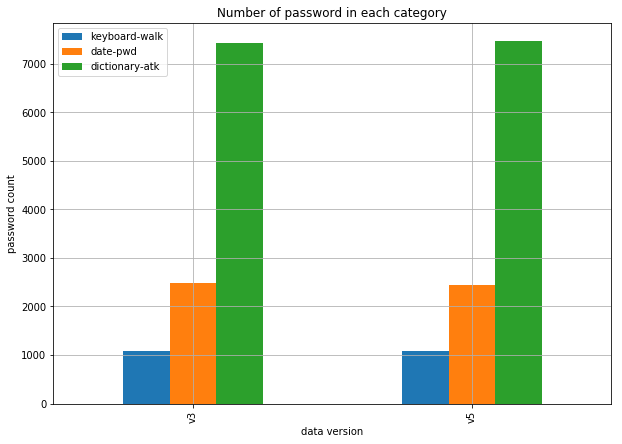

In [458]:
ax = plot_this.loc[:,['keyboard-walk','date-pwd','dictionary-atk']].plot.bar(stacked=False,
                                                                        figsize=(10,7),
                                                                        grid=True,
                                                                        title='Number of password in each category')
ax.set_xlabel("data version")
ax.set_ylabel("password count")
plt.savefig("positive-results")

## Fruther exploration 2
During the course of this project, it was evident that the longer the password, the higher the entropy. That is, the number of possible character combinations increase exponentially with every unit increase in password length. This is intuitive as longer passwords are more difficult to guess. The plot below looks at the length of the passwords and their distribution.

In [459]:
dict_atk_len = hashedlistv3[hashedlistv3["dictionary-atk"] == True]
dict_atk_len = dict_atk_len.groupby("length").count()
dict_atk_len = dict_atk_len[1:]
dict_atk_len = pd.DataFrame(dict_atk_len["count"])
walk_atk_len = hashedlistv3[hashedlistv3["keyboard-walk"] == True]
walk_atk_len = walk_atk_len.groupby("length").count()
walk_atk_len = walk_atk_len[1:]
walk_atk_len = pd.DataFrame(walk_atk_len["count"])
combined = dict_atk_len.join(walk_atk_len, on="length", rsuffix="_keyboardwalk")
combined = combined.rename(columns={"count": "count_dict-atk"})

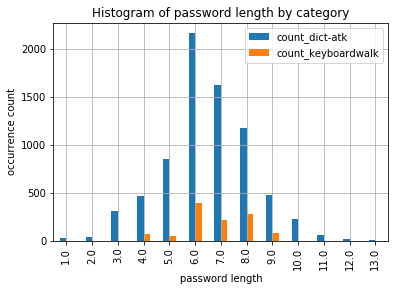

In [460]:
ax = combined.plot.bar(grid=True, title='Histogram of password length by category')
ax.set_xlabel("password length")
ax.set_ylabel("occurrence count")
plt.savefig("hist")

## Fruther exploration 2
The most common password length appears to be between 6-8 character. The trend is evident in both dictionary attack and keyboard walk type of passwords. Interestingly, there is a dip in 7-character long keyboard walk type of password. This could be because the nature of the keyboard layout. Generating a 7-letter sequence on a keyboard does not form a memorable patter and hence users are likely to opt for 6 or 8 letter passwords instead.

## Research Qn. 2:
How do the counts of the different categories of compromised passwords change within a year?  
To answer this, we need to merge both dataframe versions and compare the changes in the count value

In [461]:
count_delta = hashedlistv3.join(hashedlistv5[["hash", "count"]].set_index("hash"), on="hash", rsuffix="_new", how='left')

In [462]:
count_delta["delta"] = count_delta["count_new"] - count_delta["count"]
count_delta["delta_percent"] = count_delta["delta"] / count_delta["count"] * 100
count_delta["rank"] = count_delta.index
count_delta.head()

,hash,count,length,keyboard-walk,date-pwd,dictionary-atk,count_new,delta,delta_percent,rank
0,7C4A8D09CA3762AF61E59520943DC26494F8941B,22390492,6.0,True,False,False,23547453.0,1156961.0,5.167198,0
1,F7C3BC1D808E04732ADF679965CCC34CA7AE3441,7481454,9.0,True,False,False,7799814.0,318360.0,4.255323,1
2,B1B3773A05C0ED0176787A4F1574FF0075F7521E,3752262,6.0,True,False,False,3912816.0,160554.0,4.278859,2
3,5BAA61E4C9B93F3F0682250B6CF8331B7EE68FD8,3533661,8.0,False,False,True,3730471.0,196810.0,5.569578,3
4,3D4F2BF07DC1BE38B20CD6E46949A1071F9D0E3D,3006809,0.0,False,False,False,3120735.0,113926.0,3.788934,4


In [463]:
keyboard_walk_v3_count = int(count_delta.groupby("keyboard-walk").mean()["delta"][1:2])
date_pwd_v3_count = int(count_delta.groupby("date-pwd").mean()["delta"][1:2])
dictionary_v3_count = int(count_delta.groupby("dictionary-atk").mean()["delta"][1:2])
count_delta_plot = pd.DataFrame({"Average count increase":[keyboard_walk_v3_count,
                                                      date_pwd_v3_count,
                                                      dictionary_v3_count]})
count_delta_plot.index = ["keyboard-walk", "date-pwd", "dictionary-atk"]
count_delta_plot

,Average count increase
keyboard-walk,3067
date-pwd,113
dictionary-atk,738


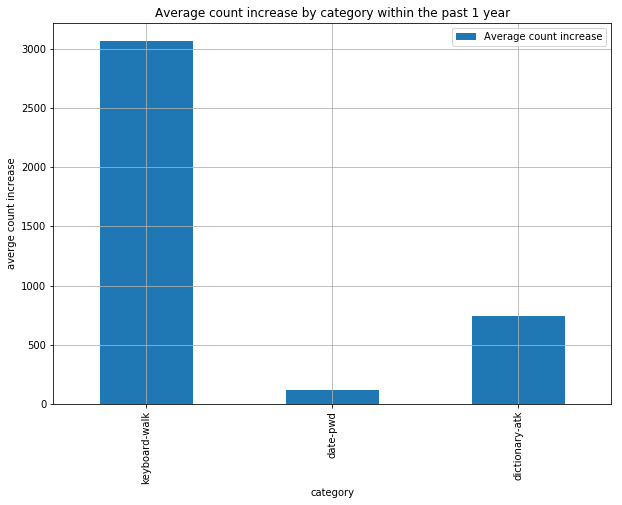

In [464]:
ax = count_delta_plot.loc[:,['Average count increase']].plot.bar(stacked=False,
                                                            figsize=(10,7),
                                                            grid=True,
                                                            title='Average count increase by category within the past 1 year')
ax.set_xlabel("category")
ax.set_ylabel("averge count increase")
plt.savefig("avg-count-increase")

## Result:
From above, we can see that if we were to look at the average change in the count value for each category, the category with passwords that are higher on the list is likely to show the largest movement.  
That is likely to be the case for noticeably high average count increase for keyboard walk. Consecutive letters such as "123456" or "qwerty" never fail to top the list of worst passwords. As such, when more data dumps take place, the common passwords have their counts increase more significantly than the less commom ones.  
This prompts us to look at a more normalized measurement of the count increment from July 2018(V3) to July 2019(V5) data. In the next section, the value of change is measured in percent instead.

In [465]:
keyboard_walk_v3_pct = float(count_delta.groupby("keyboard-walk").mean()["delta_percent"][1:2])
date_pwd_v3_pct = float(count_delta.groupby("date-pwd").mean()["delta_percent"][1:2])
dictionary_v3_pct = float(count_delta.groupby("dictionary-atk").mean()["delta_percent"][1:2])
pct_delta = pd.DataFrame({"Average percent increase":[keyboard_walk_v3_pct,
                                                      date_pwd_v3_pct,
                                                      dictionary_v3_pct]})
pct_delta.index = ["keyboard-walk", "date-pwd", "dictionary-atk"]
pct_delta

,Average percent increase
keyboard-walk,3.456000
date-pwd,2.810635
dictionary-atk,3.755931


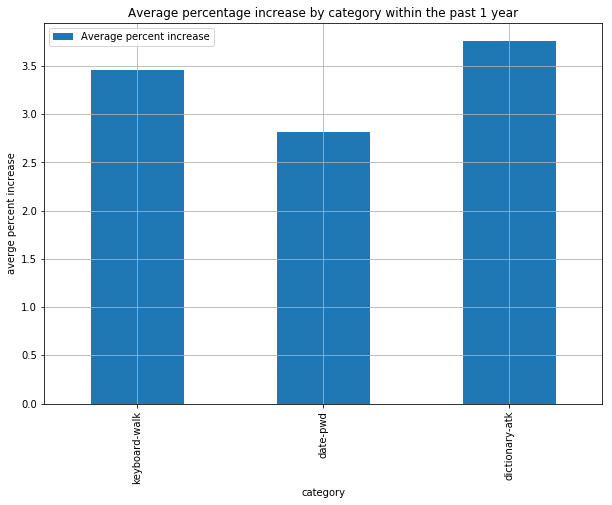

In [466]:
ax = pct_delta.loc[:,['Average percent increase']].plot.bar(stacked=False,
                                                       figsize=(10,7),
                                                       grid=True,
                                                       title='Average percentage increase by category within the past 1 year')
ax.set_xlabel("category")
ax.set_ylabel("averge percent increase")
plt.savefig("avg-percent-increase")

## Result:
The average percentage change for each category is more comparable now. It is notable that the dictionary attack type of password sees a higher average percentage increase than keyboard walk category. This could be the case where users are now avoiding the extremely easy passwords that are likely to fal under keyboard walk and adopt more complicated passwords that can only be guessed by a compiled list of dictionary attack.

## Fruther exploration 3
Despite being quite a significant portion of the categorized dataset, the date-formatted passwords have a rather unique distribution. While exploring a small portion of most vulnerable passwords, the proprtion of the date-pwd is almost negligible. The proportion became significant only then the number of passwords subsetted reached 50,000. This section aims to explore the average rank of each category of identified passwords.

In [467]:
keyboard_walk_v3_rank = float(count_delta.groupby("keyboard-walk").mean()["rank"][1:2])
date_pwd_v3_rank = float(count_delta.groupby("date-pwd").mean()["rank"][1:2])
dictionary_v3_rank = float(count_delta.groupby("dictionary-atk").mean()["rank"][1:2])
rank = pd.DataFrame({"Average rank":[keyboard_walk_v3_rank,
                                     date_pwd_v3_rank,
                                     dictionary_v3_rank]})
rank.index = ["keyboard-walk", "date-pwd", "dictionary-atk"]
rank

,Average rank
keyboard-walk,17802.436750
date-pwd,40955.048329
dictionary-atk,18555.423206


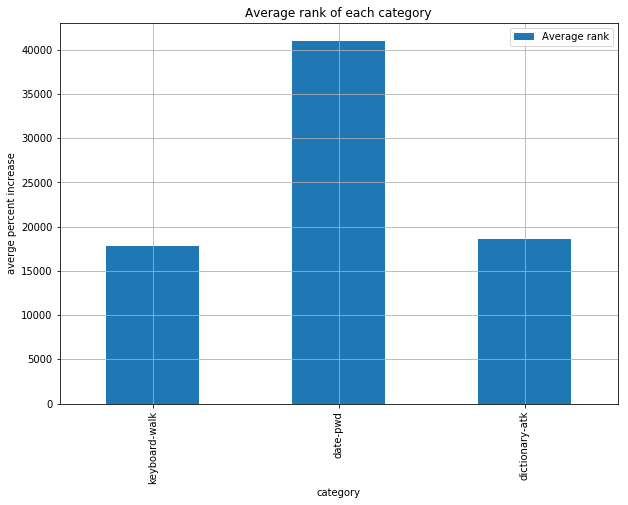

In [468]:
ax = rank.loc[:,['Average rank']].plot.bar(stacked=False,
                                                figsize=(10,7),
                                                grid=True,
                                                title='Average rank of each category')
ax.set_xlabel("category")
ax.set_ylabel("averge percent increase")
plt.savefig("avg-percent-increase")

## Fruther exploration 3
We can se that the "date-pwd" type of password have a significantly higher average rank than the other two characters. This shows that they are more common around the 40,000th most vulnerable passwords while the other two categories are distributed more uniformly.

---

# Reflection
Dealing with passwords can involve sensitive data. Working on this project has given me the chance to attempt to work with compromised passwords dataset without actually exposing them. The process is inspired by Troy Hunt's decision to release a hashed password dataset instead of just releasing the actual password.  
This project is also challlenging when it comes to reproducibility. More than a data visualization project, this notebook include complicated Python scripts to generate and hash permutations of possible passwords so that they can be checked against the hashed password dataset by Troy. Some of the script is extremely compute-intensive and that may affect the reproducibility. As such, the decision to include a checkpoint file was make to allow quick verification of the findings in this report. For individuals who wish to dive further, the boolean values of "checkpoint" and "keyboard_rerun" can be changed to accommodate such endeavor.  
Coming up with the categories of the password was also a human centric process. Users tend to use something they are familiar with as their passwords since forgetting the passwords can be very inconvenient. This compels us to create some sort of mnemonic to help us remember. Following this train of thought has led to the categories of keyboard walk and date-formatted passwords. Other potential categories are phone number, addresses and words or phrases from rhymes. These categories were not considered partly due to time contraints and their complexity.